# PDAC single ligand dataset validation experiments preprocessing
#### _CK, BEM 2022_

### What this does:
- Makes a single anndata file containing the scRNA-seq data and the outputs of running cNMF on the data
- Visualizes the validation cNMF modules and identifies those that are highly correlated with the highly variable CS cNMF modules

In [1]:
import os
import sys
import warnings
import random
import itertools
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
from kneed import KneeLocator

from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
from cnmf import cNMF

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

sc.settings.verbosity = 3           # verbosity: errors (0), warnings (1), info (2), hints (3)

## Prep anndata

#### metadata helper

In [2]:
def add_design_matrix(adata, plate_design_path):
    # Load design matrix
    plate1_design = pd.read_csv(plate_design_path,index_col=0)
    plate1_design = plate1_design.rename(columns={'TNF':'TNFa', 'TGFB1':'TGFbeta1'})

    # Add Metadata_perturbation to anndata: based on design matrix
    Metadata_perturbation = ['random']*len(plate1_design.index)
    Controls = (np.sum(plate1_design, axis = 1) == 0)
    Landmarks = (np.sum(plate1_design, axis = 1) == 1)

    # Build list of perturbations
    for i in list(range(len(Metadata_perturbation))):
        if Controls[i]:
            Metadata_perturbation[i] = 'Control'
        elif Landmarks[i]:
            Metadata_perturbation[i] = plate1_design.columns[plate1_design.iloc[i,:] == 1][0]

    # Add well as index
    Metadata_perturbation = pd.DataFrame(Metadata_perturbation, 
                                         columns = ['Metadata_perturbation'], 
                                         index = plate1_design.index).reset_index()

    # Map back to anndata
    Metadata_perturbation = pd.DataFrame(adata.obs['sample_well']).rename(columns={'sample_well':'index'}).\
                            merge(Metadata_perturbation,how='left',on='index').\
                            drop(['index'],axis=1)

    adata.obs['Metadata_perturbation'] = Metadata_perturbation.Metadata_perturbation.values

    # add metadata for landmarks
    LM_list = list(set(adata.obs.Metadata_perturbation.values)-set(['random']))

    LM_df = pd.DataFrame(columns = LM_list)

    for LM in LM_list:
        LM_df[LM] = (adata.obs.Metadata_perturbation == LM)
        LM_df[LM] = adata.obs.Metadata_perturbation[(adata.obs.Metadata_perturbation == LM)]

        adata.obs[LM] = LM_df[LM]

    adata.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
    adata.obs.loc[adata.obs.landmarks == '', 'landmarks'] = np.nan

    # Add Design matrix to anndata
    plate1_design = plate1_design.reset_index()
    adata.obs['index'] = adata.obs['sample_well']

    design_mat = pd.DataFrame(adata.obs['index']).\
                 merge(plate1_design,how='left',on='index').\
                 drop(['index'],axis=1)

    adata.obsm['design_matrix']=np.array(design_mat)
    adata.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()
    adata.obs = adata.obs.drop(columns=['index'])
    
    return(adata)



#### cell # plotting

In [3]:
def cell_num_plot(adata, fig_name):
    
    # Make table of cells by perturbations
    cell_num_pert = pd.DataFrame(adata.obsm['design_matrix_with_media'], 
                                 columns = adata.uns['design_matrix_perturbations_with_media'], 
                                 index = adata.obs.index)

    cell_num_pert.loc[:,'media'] = (cell_num_pert.iloc[:,:-1].sum(axis=1)==0)*1

    # Review cell # per perturbation
    p_cell_num_pert = plot_cell_num_pert(cell_num_pert, fig_name)

    summary_cell_num = pd.DataFrame(cell_num_pert.sum(axis=0),columns = ['cell_#']).sort_values(by='cell_#')
    
    print('3 highest perturbations:')
    print(summary_cell_num.iloc[-4:-1,:])
    print('3 lowest perturbations:')
    print(summary_cell_num.iloc[:3,:])
    
    return(summary_cell_num)


In [4]:
def cell_num_downsample_plot(plot_cell_num_pert, fig_name):
    
    g = sns.histplot(plot_cell_num_pert, x='cell_#', legend = True,
                 element="step", multiple='layer', stat='density', bins = 20,
                 hue="type", palette=['grey', 'red'])

    g.figure.savefig('figures/'+fig_name+'.pdf');

        
def plot_cell_num_pert(cell_num_pert, fig_name):
    
    plot_cell_num_pert = pd.DataFrame(cell_num_pert.sum(axis=0),
                                  columns = ['cell_#'])
    plot_cell_num_pert['type'] = 'perturbation'
    plot_cell_num_pert.iloc[-1,1] = 'media'
    
    cell_num_downsample_plot(plot_cell_num_pert, fig_name)
    
    return(plot_cell_num_pert)

### Paths to files

In [5]:
sc.logging.print_header()

/opt/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [6]:
h5ad_path = '../../../PDAC_validation_data_lock/PDAC_manu_validation_sept9_data_lock/'

valid1_d7_input = h5ad_path + 'd7_valdation1/1_Preprocess/PDAC_SSwl_d7_valid1_demulti_g500_BEM_20220909.h5ad'
valid2_d7_input = h5ad_path + 'd7_d21_validation2/1_Preprocess/PDAC_SSwl_EA320_d7_demulti_g500_BEM_20220909.h5ad'
valid2_d21_input = h5ad_path + 'd7_d21_validation2/1_Preprocess/PDAC_SSwl_EA320_d21_demulti_g500_BEM_20220909.h5ad'

CS_data_input = '../2_screen_analysis_combined_cNMF/h5ad_files/plate1_2_concat_adata.h5ad'

### Experimental conditions

In [7]:
# Conditions to look at across expts
media = 'OWRNA'
donor = '562'

### Validation 1

In [10]:
# Load validation 1 day 7 star solo - QC/preprocess/demulti in seurat
adata = sc.read(valid1_d7_input)
del adata.raw
adata.var.index = adata.var._index
adata.var.index.rename(name='index', inplace=True)
del adata.var['_index']

# Clean up metadata\
metadata_to_drop = ['orig.ident', 'array', 'nCount_HTO', 'nFeature_HTO', 
                    'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification',
                    'HTO_classification.global', 'hash.ID', 'plate_column']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)
adata.obs['time'] = 7

# Rename perturbations 
adata.obs = adata.obs.replace('TGFb1','TGFbeta1')
adata.obs = adata.obs.replace('IFNg','IFNG')
adata.obs = adata.obs.replace('CONTROL','Control')
adata.obs['Metadata_perturbation'] = adata.obs['sample']

# Filter to matching experimental conditions
adata = adata[(adata.obs.media == media) & (adata.obs.donor == donor)]
adata.obs = adata.obs.drop(['media','donor','sample'], axis=1)

print("data shape:", adata.shape)

valid1 = adata
valid1.obs['plate'] = 'valid1'

# Select variable genes - valid1
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)
valid1_hvg = adata.var['highly_variable'][adata.var['highly_variable']].index.values


data shape: (2284, 13053)
extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


### Validation 2

In [21]:
# Load validation 2 day 7 star solo - QC/preprocess/demulti in seurat
adata = sc.read(valid2_d7_input)
del adata.raw
adata.var.index = adata.var._index
adata.var.index.rename(name='index', inplace=True)
del adata.var['_index']

# Clean up metadata\
metadata_to_drop = ['orig.ident', 'array', 'nCount_HTO', 'nFeature_HTO', 
                    'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification',
                    'HTO_classification.global', 'hash.ID', 'plate_column']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)
adata.obs['time'] = 7

# Rename perturbations 
adata.obs = adata.obs.replace('TGFb1','TGFbeta1')
adata.obs = adata.obs.replace('IFNg','IFNG')
adata.obs = adata.obs.replace('CONTROL','Control')
adata.obs['Metadata_perturbation'] = adata.obs['sample']

# Filter to matching experimental conditions
adata = adata[(adata.obs.media == media) & (adata.obs.donor == donor)]
adata.obs = adata.obs.drop(['media','donor','sample'], axis=1)

print("data shape:", adata.shape)

valid2_d7 = adata

# Load validation 2 day 21 star solo - QC/preprocess/demulti in seurat
adata = sc.read(valid2_d21_input)
del adata.raw
adata.var.index = adata.var._index
adata.var.index.rename(name='index', inplace=True)
del adata.var['_index']

# Clean up metadata\
metadata_to_drop = ['orig.ident', 'array', 'nCount_HTO', 'nFeature_HTO', 
                    'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification',
                    'HTO_classification.global', 'hash.ID', 'plate_column']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)
adata.obs['time'] = 21

# Rename perturbations 
adata.obs = adata.obs.replace('TGFb1','TGFbeta1')
adata.obs = adata.obs.replace('IFNg','IFNG')
adata.obs = adata.obs.replace('CONTROL','Control')
adata.obs['Metadata_perturbation'] = adata.obs['sample']

# Filter to matching experimental conditions
adata = adata[(adata.obs.media == media) & (adata.obs.donor == donor)]
adata.obs = adata.obs.drop(['media','donor','sample'], axis=1)

print("data shape:", adata.shape)

valid2_d21 = adata

# merge validation data
var_names = valid2_d7.var_names.intersection(valid2_d21.var_names)
valid2_d7 = valid2_d7[:, var_names]
valid2_d21 = valid2_d21[:, var_names]

valid2 = valid2_d7.concatenate(valid2_d21, batch_categories=['valid2_d7', 'valid2_d21'])
valid2.obs['plate'] = 'valid2'

print("data shape:", valid2.shape)

# Select variable genes - valid2
adata = valid2
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)
valid2_hvg = adata.var['highly_variable'][adata.var['highly_variable']].index.values

/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


data shape: (9891, 18332)


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


data shape: (1787, 16783)
data shape: (11678, 16775)
extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


In [22]:
# save variable genes to file

file=open('h5ad_files/valid_batch2_concat_hvg.txt','w')
for gene in valid2_hvg:
    file.writelines(gene+'\n')
file.close()

# Save adata
adata.write('h5ad_files/valid_batch2_concat_adata.h5ad')

### CS plate controls + landmarks

In [12]:
# Load Compressed Screen plate1+2 star solo - QC/preprocess/demulti in seurat
adata = sc.read(CS_data_input)
del adata.uns['design_matrix_perturbations']
del adata.obsm['design_matrix']
del adata.obsm['design_matrix_with_media']

# Clean up metadata
metadata_to_drop = ['TGFbeta1', 'IFNG', 'TNFa', 'Control', 'landmarks']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)
adata.obs['time'] = 7
adata.obs['plate'] = adata.obs['batch']

# Filter to matching experimental conditions
adata = adata[adata.obs.Metadata_perturbation.isin(['TGFbeta1', 'IFNG', 'TNFa', 'Control'])]

print("data shape:", adata.shape)

plate1_2 = adata

# Select variable genes - plate1_2
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)
plate1_2_hvg = adata.var['highly_variable'][adata.var['highly_variable']].index.values

data shape: (3701, 15876)
extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


### Combine validations and plate1&2 - get hvg and save

In [13]:
# merge datasets
var_names = valid2.var_names.intersection(valid1.var_names).intersection(plate1_2.var_names)
plate1_2 = plate1_2[:, var_names]
valid2 = valid2[:, var_names]
valid1 = valid1[:, var_names]

adata_concat = plate1_2.concatenate([valid1, valid2], batch_categories=['plate1_2', 'valid1', 'valid2'])
adata_concat.obs['batch'] = adata_concat.obs['plate']
adata_concat.obs = adata_concat.obs.drop('plate', axis=1)

print("data shape:", adata_concat.shape)

# Select variable genes - combined
sc.experimental.pp.highly_variable_genes(adata_concat, flavor="pearson_residuals", n_top_genes=3000)

# save variable genes to file
concat_hvg = adata_concat.var['highly_variable'][adata_concat.var['highly_variable']].index.values

file=open('h5ad_files/valid_concat_hvg.txt','w')
for gene in concat_hvg:
    file.writelines(gene+'\n')
file.close()

# Save adata
adata_concat.write('h5ad_files/valid_concat_adata.h5ad')

data shape: (17663, 12963)
extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


In [14]:
# Save union hvg from top 2000 of each batch
union_hvg = set(valid1_hvg).union(set(valid2_hvg)).union(set(plate1_2_hvg))
union_hvg = list(union_hvg.intersection(set(adata_concat.var['features'])))

file=open('h5ad_files/valid_batch_union_hvg.txt','w')
for gene in union_hvg:
    file.writelines(gene+'\n')
file.close()

### Combine d7 validation data - get hvg and save

In [20]:
# merge datasets
var_names = valid2.var_names.intersection(valid1.var_names).intersection(plate1_2.var_names)
plate1_2 = plate1_2[:, var_names]
valid2 = valid2[:, var_names]
valid1 = valid1[:, var_names]

adata_concat = plate1_2.concatenate([valid1, valid2], batch_categories=['plate1_2', 'valid1', 'valid2'])
adata_concat.obs['batch'] = adata_concat.obs['plate']
adata_concat.obs = adata_concat.obs.drop('plate', axis=1)

# subset to day 7
adata_concat = adata_concat[adata_concat.obs['time']==7]

# Select variable genes - combined
sc.experimental.pp.highly_variable_genes(adata_concat, batch_key='batch',
                                         flavor="pearson_residuals", n_top_genes=3000)

# save variable genes to file
concat_hvg = adata_concat.var['highly_variable'][adata_concat.var['highly_variable']].index.values

file=open('h5ad_files/valid_day7_concat_hvg.txt','w')
for gene in concat_hvg:
    file.writelines(gene+'\n')
file.close()

# Save adata
adata_concat.write('h5ad_files/valid_day7_concat_adata.h5ad')

extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


## Ingest + finish cNMF

### Functions

In [11]:
# Find knee

def get_knee_list(module_usage, S):
    """
    module_usage: pd.Series
    """
    
    y = module_usage.values
    x=range(1, len(y)+1)
    kn = KneeLocator(x, y, S=S, online=False, curve='convex', direction='decreasing')
    knee_val = kn.knee
        
    return(module_usage.index.values[0:knee_val])

In [12]:
def find_top_GEP(k,density_threshold,path_to_cnmf,cnmf_run,mod_prefix,knee_sens = 3):

    ## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
    gene_scores = pd.read_csv(path_to_cnmf+'/'+cnmf_run+'.spectra.k_'+k+'.dt_'+density_threshold+'.consensus.txt',
                              sep='\t', index_col=0).T.add_prefix(mod_prefix)
    
    ## Obtain the top genes (knee method) for each GEP in sorted order, 
    ## and combine them into a single dataframe
    top_genes = []
    for gep in gene_scores.columns:
        gene_list = list(get_knee_list(gene_scores.loc[:,gep].sort_values(ascending=False),S=knee_sens))        
        top_genes.append(gene_list)

    top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
    
    ## Load in the cell usage scores for the modules
    usage = pd.read_csv(path_to_cnmf+'/'+cnmf_run+'.usages.k_'+k+".dt_"+density_threshold+'.consensus.txt' ,
                        sep='\t', index_col=0).add_prefix(mod_prefix)
    
    # Normalize
    usage = usage.div(usage.sum(axis=1), axis=0)
    
    return(gene_scores, top_genes, usage)

In [13]:
def filtered_usages(usages, new_module_dict):
    
    filtered_usages = usages.loc[:,usages.columns.isin(list(new_module_dict.keys()))]
    filtered_usages = filtered_usages.rename(columns = new_module_dict)
    filtered_usages.columns = ['Module_%s' % i for i in filtered_usages.columns]
    
    return(filtered_usages)
    

In [14]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [15]:
def plate_module_matching(p1_gene_scores, p2_gene_scores, p1_top_genes, p2_top_genes, p1_usages, p2_usages,
                          file_name, jac_cutoff = 0.25, corr_cutoff = 0.5, filter_to_top = False):

    combined_gene_scores = p1_gene_scores.merge(p2_gene_scores, how='inner',left_index=True, right_index=True)

    # Create top gene correlation + jaccard matrix
    corr_matrix = pd.DataFrame(np.zeros((len(p1_gene_scores.columns),len(p2_gene_scores.columns))),
                               index=p1_gene_scores.columns.values,
                               columns=p2_gene_scores.columns.values)

    jac_matrix = pd.DataFrame(np.zeros((len(p1_gene_scores.columns),len(p2_gene_scores.columns))),
                               index=p1_gene_scores.columns.values,
                               columns=p2_gene_scores.columns.values)

    for p1_mod in p1_gene_scores.columns.values:
        for p2_mod in p2_gene_scores.columns.values:

            # union of top genes
            set_p1 = set(p1_top_genes[p1_mod].values.tolist())
            set_p2 = set(p2_top_genes[p2_mod].values.tolist())
            top_genes = list(set_p1.union(set_p2))

            # populate jaccard matrix
            jac_matrix.loc[p1_mod,p2_mod] = jaccard(set_p1, set_p2)

            # populate corr matrix
            corr = combined_gene_scores.loc[:,combined_gene_scores.columns.isin([p1_mod,p2_mod])].corr().iloc[0,1]
            corr_matrix.loc[p1_mod,p2_mod] = corr
    
    # Select modules from each plate with peason r > cor_cutoff with at least 1 module from other plate
    keep_p1 = np.sum(corr_matrix > corr_cutoff, axis=0) > 0
    keep_p2 = np.sum(corr_matrix > corr_cutoff, axis=1) > 0

    filtered_corr_matrix = corr_matrix.loc[keep_p2, keep_p1]
    filtered_jac_matrix = jac_matrix.loc[keep_p2, keep_p1]
    
    if filter_to_top == True:
        # If given module in p1 (validation) matches >1 in p2 (CS), take highest correl.
        p1_max = filtered_corr_matrix.apply('idxmax', axis=0).values

        filtered_corr_matrix = filtered_corr_matrix.loc[filtered_corr_matrix.index.isin(p1_max),:]
        filtered_jac_matrix = filtered_jac_matrix.loc[filtered_jac_matrix.index.isin(p1_max),:]
        
        file_name = file_name+'_top_mod'

    # filter to top modules
    p1_top_mods = p1_top_genes.columns.isin(filtered_corr_matrix.index)
    p1_top_genes = p1_top_genes.loc[:,p1_top_mods].dropna(how='all')
    
    p2_top_mods = p2_top_genes.columns.isin(filtered_corr_matrix.columns)
    p2_top_genes = p2_top_genes.loc[:,p2_top_mods].dropna(how='all')
    
    # save top genes p1 (validation)
    p1_top_genes.to_csv("figures/p1_corr>"+str(corr_cutoff)+'_'+file_name+"_top_genes.csv")
        
    # filter usages + save  p1 (validation)
    p1_usages.loc[:,p1_top_mods].to_csv("figures/p1_corr>"+str(corr_cutoff)+'_'+file_name+"_normd_usages.csv")
    
    # make some plots
    fig = sns.clustermap(filtered_corr_matrix, cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize = (7.5,7.5),
                         method = 'weighted', dendrogram_ratio = 0.1, colors_ratio = 0.5, linewidths=.5,
                         cbar_pos=(1, 0.8, 0.025, 0.1))
    
    new_row_order = list(filtered_corr_matrix.iloc[fig.dendrogram_row.reordered_ind,:].index.values)
    new_col_order = list(filtered_corr_matrix.iloc[:,fig.dendrogram_col.reordered_ind].columns.values)
    
    fig.savefig('figures/GEP_corr>'+str(corr_cutoff)+'_'+file_name+'_plot.pdf')
    
    filtered_jac_matrix = filtered_jac_matrix.reindex(new_row_order)
    filtered_jac_matrix = filtered_jac_matrix.reindex(columns = new_col_order)
    
    fig = sns.clustermap(filtered_jac_matrix, cmap="rocket_r",
                         vmin=0, vmax=0.5, figsize = (7.5,7.5),
                         row_cluster=False, col_cluster=False, mask = (filtered_jac_matrix < jac_cutoff),
                         dendrogram_ratio = 0.1, colors_ratio = 0.5, linewidths=.5,
                         cbar_pos=(1, 0.8, 0.025, 0.1))
    
    fig.savefig('figures/GEP_corr>'+str(corr_cutoff)+'_'+file_name+'_jaccard_plot.pdf')
    

### Validation single run

In [45]:
knee_sens = 2

output_directory = 'cnmf_output/valid_batch_union_concat/'
run_name = 'cnmf_run'

p1_gene_scores, p1_top_genes, p1_usages = find_top_GEP(k='28',
                                                      density_threshold='0_20',
                                                      path_to_cnmf=output_directory,
                                                      cnmf_run=run_name,
                                                      mod_prefix='Module_',
                                                      knee_sens = knee_sens)

In [ ]:
file_name = "k_28_valid_concat_knee_2"

p1_top_genes.to_csv("figures/"+file_name+"_top_genes.csv", index=False)
p1_usages.to_csv("figures/"+file_name+"_normd_usages.csv")
p1_gene_scores.to_csv("figures/"+file_name+"_gene_scores.csv")

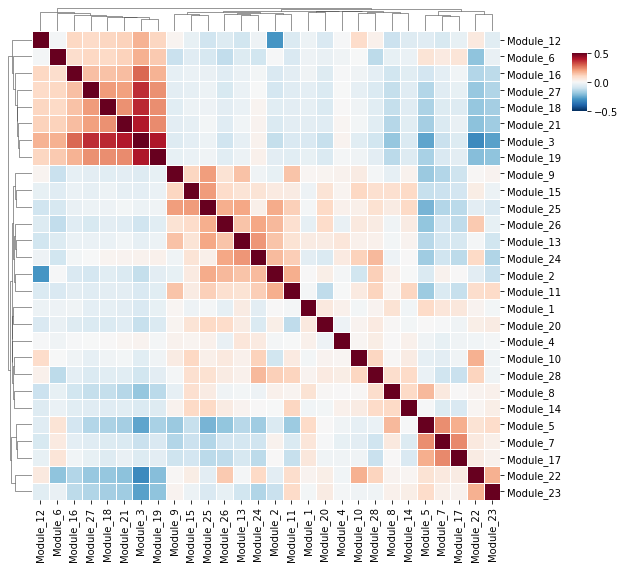

In [46]:
# make some plots
fig = sns.clustermap(p1_usages.corr(method='spearman'), cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize = (8,8),
                     method = 'weighted', dendrogram_ratio = 0.05, colors_ratio = 0.5, linewidths=.5,
                     cbar_pos=(1, 0.8, 0.025, 0.1))

In [9]:
p2_gene_scores = pd.read_csv('../2_screen_analysis_combined_cNMF/figures/p1_2_k_26_combined_knee_2_gene_scores_filtered.csv',
                             index_col=0).add_prefix('CS_')
p2_normd_usages = pd.read_csv('../2_screen_analysis_combined_cNMF/figures/p1_2_k_26_combined_knee_2_normd_usages_filtered.csv',
                              index_col=0).add_prefix('CS_')
p2_top_genes = pd.read_csv('../2_screen_analysis_combined_cNMF/figures/p1_2_k_26_combined_knee_2_top_genes_filtered.csv').add_prefix('CS_')


#### Match back to compressed plates

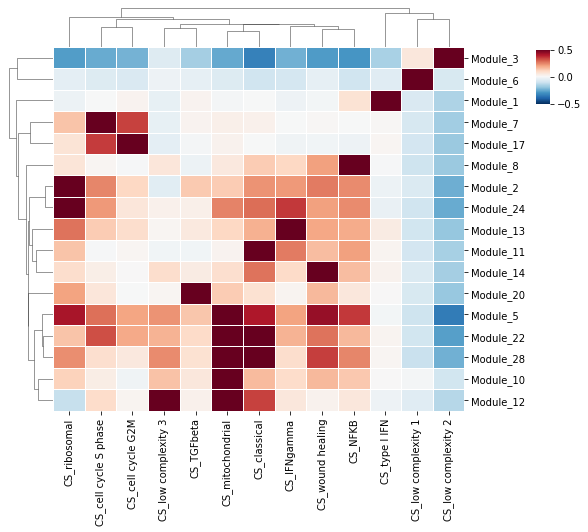

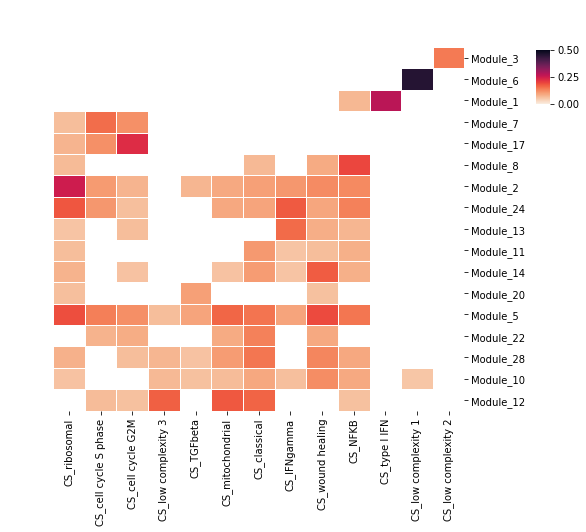

In [50]:
plate_module_matching(p1_gene_scores, p2_gene_scores,
                      p1_top_genes, p2_top_genes, 
                      p1_usages, p2_normd_usages,
                      file_name = 'p1_validation_p2_CS_union',jac_cutoff = 0.05, corr_cutoff = 0.5, 
                      filter_to_top=False)

### Validation - batch 2 (d7+d21)

In [51]:
knee_sens = 2

output_directory = 'cnmf_output/valid_batch2_concat/'
run_name = 'cnmf_run'

p1_gene_scores, p1_top_genes, p1_usages = find_top_GEP(k='34',
                                                      density_threshold='0_10',
                                                      path_to_cnmf=output_directory,
                                                      cnmf_run=run_name,
                                                      mod_prefix='Module_',
                                                      knee_sens = knee_sens)

In [52]:
file_name = "k_34_valid_batch2_concat_knee_2"

p1_top_genes.to_csv("figures/"+file_name+"_top_genes.csv", index=False)
p1_usages.to_csv("figures/"+file_name+"_normd_usages.csv")
p1_gene_scores.to_csv("figures/"+file_name+"_gene_scores.csv")

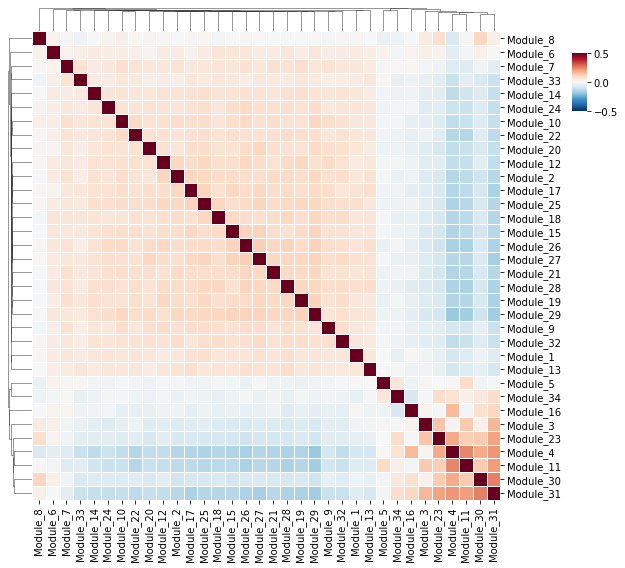

In [53]:
# make some plots
fig = sns.clustermap(p1_usages.corr(method='spearman'), cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize = (8,8),
                     method = 'weighted', dendrogram_ratio = 0.05, colors_ratio = 0.5, linewidths=.5,
                     cbar_pos=(1, 0.8, 0.025, 0.1))

#### Match back to compressed plates

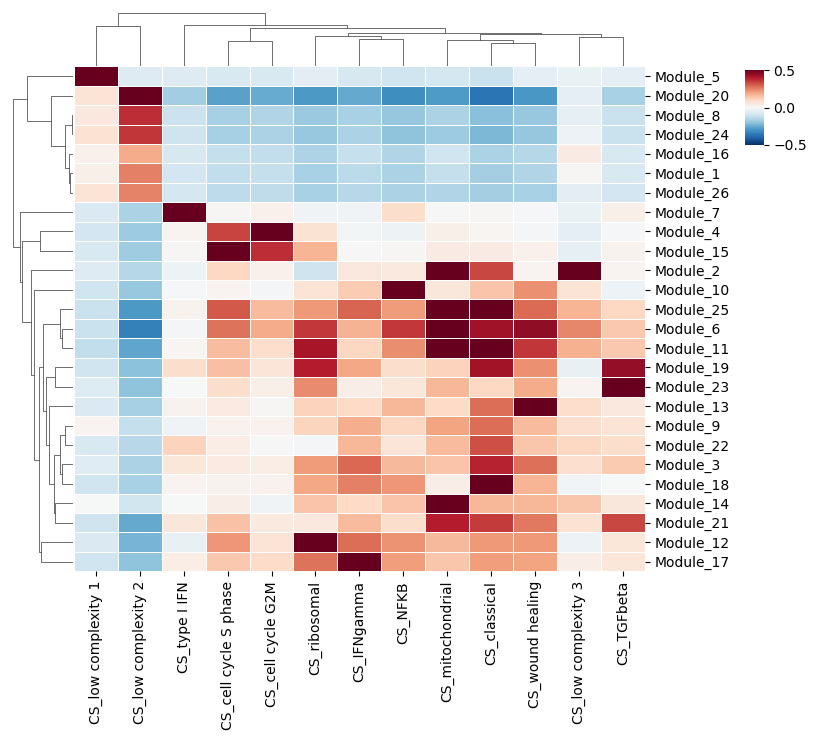

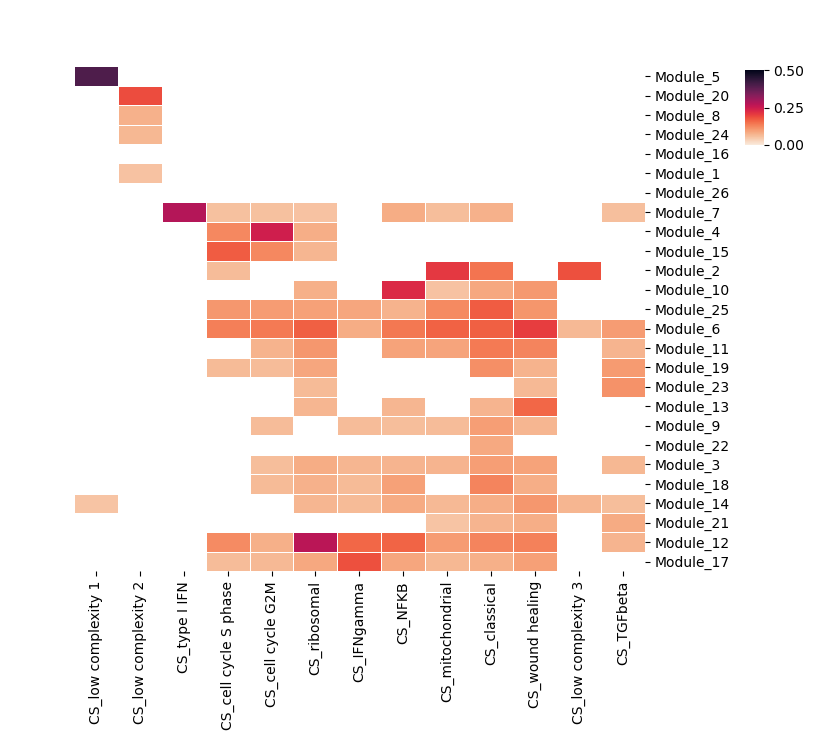

In [25]:
plate_module_matching(p1_gene_scores, p2_gene_scores,
                      p1_top_genes, p2_top_genes, 
                      p1_usages, p2_normd_usages,
                      file_name = 'p1_validation_p2_CS_batch2',jac_cutoff = 0.05, corr_cutoff = 0.125, 
                      filter_to_top=False)

### Validation d7 only

In [16]:
knee_sens = 2

output_directory = 'cnmf_output/valid_d7_concat/'
run_name = 'cnmf_run'

p1_gene_scores, p1_top_genes, p1_usages = find_top_GEP(k='26',
                                                      density_threshold='0_20',
                                                      path_to_cnmf=output_directory,
                                                      cnmf_run=run_name,
                                                      mod_prefix='Module_',
                                                      knee_sens = knee_sens)

In [10]:
file_name = "k_26_valid_d7_concat_knee_2"

p1_top_genes.to_csv("figures/"+file_name+"_top_genes.csv", index=False)
p1_usages.to_csv("figures/"+file_name+"_normd_usages.csv")
p1_gene_scores.to_csv("figures/"+file_name+"_gene_scores.csv")

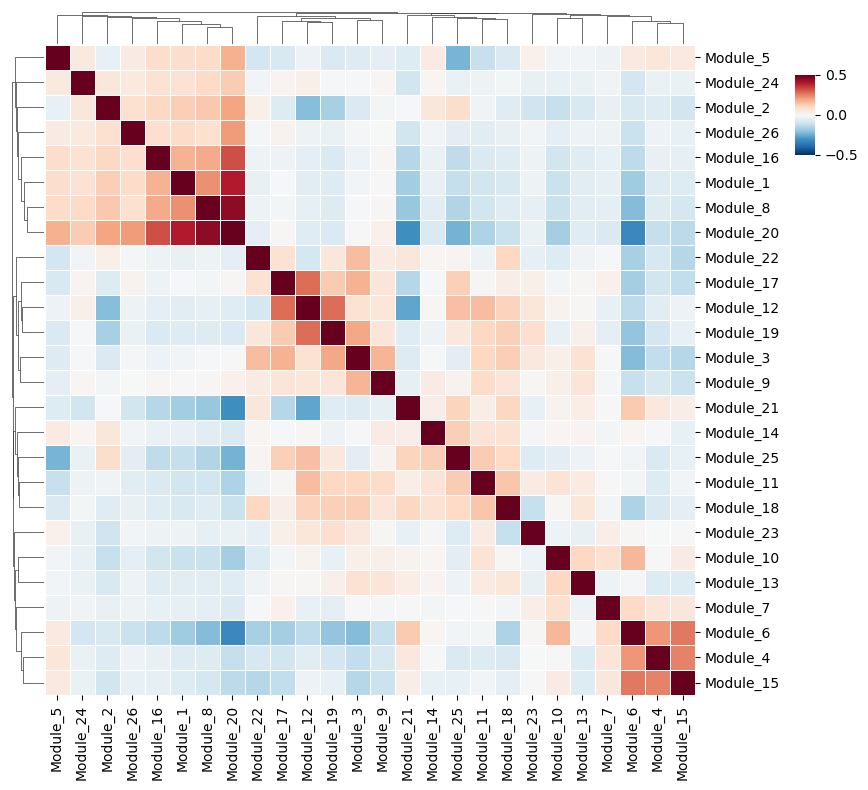

In [11]:
# make some plots
fig = sns.clustermap(p1_usages.corr(method='spearman'), cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize = (8,8),
                     method = 'weighted', dendrogram_ratio = 0.05, colors_ratio = 0.5, linewidths=.5,
                     cbar_pos=(1, 0.8, 0.025, 0.1))

#### map back to compressed

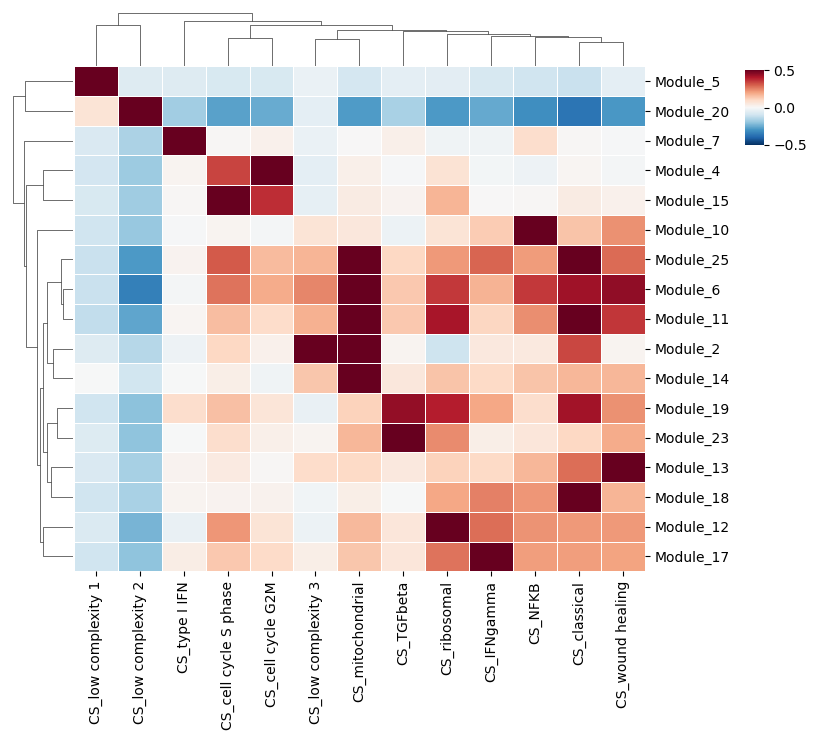

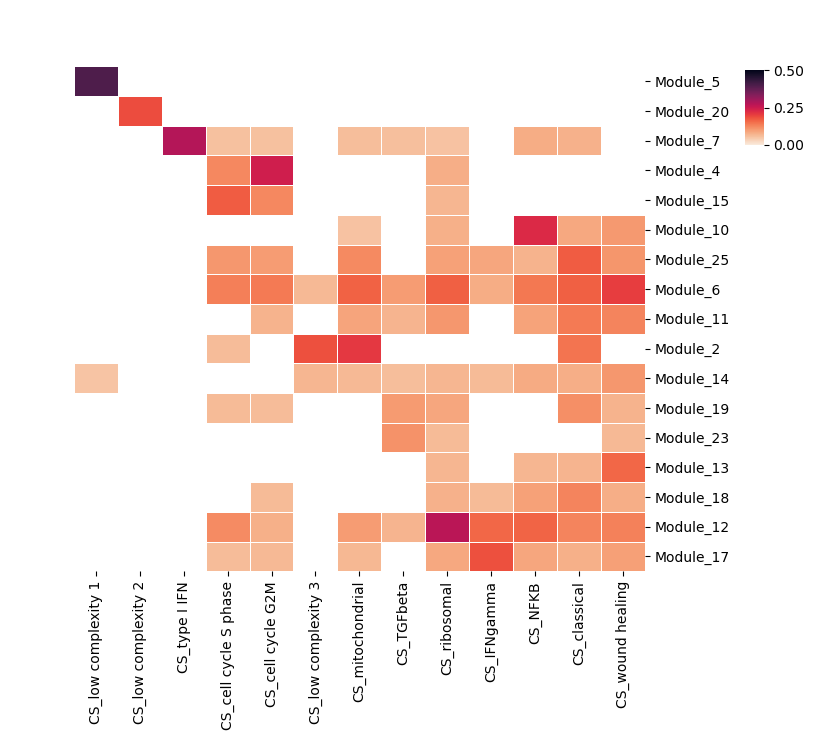

In [12]:
plate_module_matching(p1_gene_scores, p2_gene_scores,
                      p1_top_genes, p2_top_genes, 
                      p1_usages, p2_normd_usages,
                      file_name = 'p1_validation_p2_CS_d7',jac_cutoff = 0.05, corr_cutoff = 0.4, 
                      filter_to_top=False)

In [21]:
high_corr_module_naming = {
                    'Module_2':"low complexity 3",
                    'Module_4':"cell cycle G2M",
                    'Module_5':"low complexity 1",
                    # 'Module_6':"PDAC-related 1",
                    'Module_7':"type I IFN",
                    'Module_10':"NFKB",
                    # 'Module_11':"PDAC-related 2",
                    'Module_12':"ribosomal",
                    'Module_13':"wound healing",       
                    'Module_14':"mitochondrial",
                    'Module_15':"cell cycle S phase",
                    'Module_17':"IFNgamma",
                    'Module_18':"classical",
                    # 'Module_19':"PDAC-related 3",
                    'Module_20':"low complexity 2",
                    'Module_23':"TGFbeta"
                    # 'Module_25':"PDAC-related 4"
}

new_mod_order = ["NFKB",
                 "wound healing",
                 "TGFbeta",
                 "IFNgamma",
                 "type I IFN",
                 "classical",
                 "cell cycle G2M",
                 "cell cycle S phase",
                 "ribosomal",
                 "mitochondrial",
                 "low complexity 1",
                 "low complexity 2",
                 "low complexity 3"]
                #  "PDAC-related 1",
                # "PDAC-related 2",
                # "PDAC-related 3",
                # "PDAC-related 4"]

old_names = [x for x in high_corr_module_naming]
new_names = [high_corr_module_naming[x] for x in high_corr_module_naming]

In [22]:
select_p1_scores = p1_gene_scores.loc[:,old_names]
select_p1_scores.columns = new_names

select_p1_top_genes = p1_top_genes.loc[:,old_names]
select_p1_top_genes.columns = new_names

select_p1_usages = p1_usages.loc[:,old_names]
select_p1_usages.columns = new_names



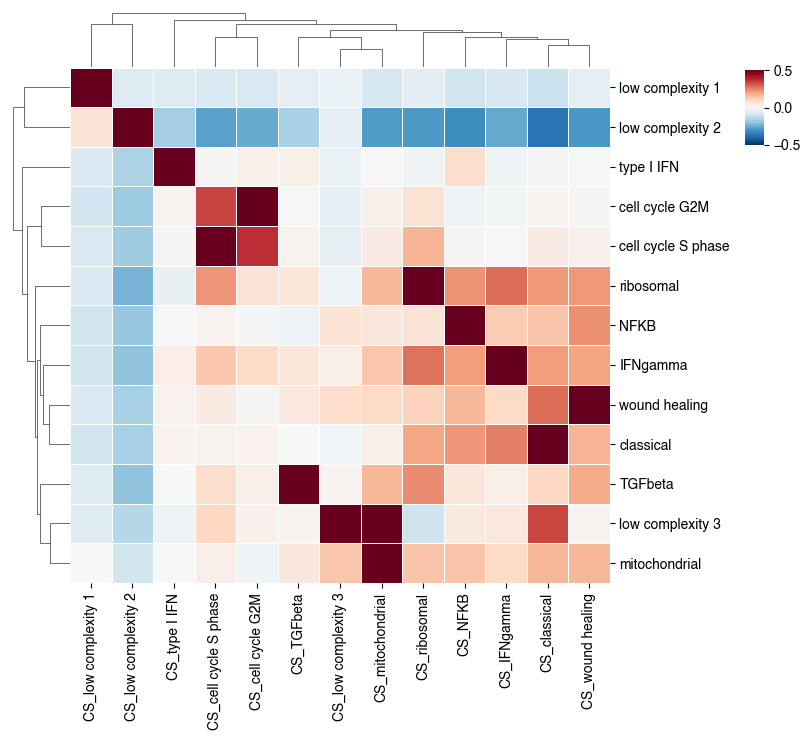

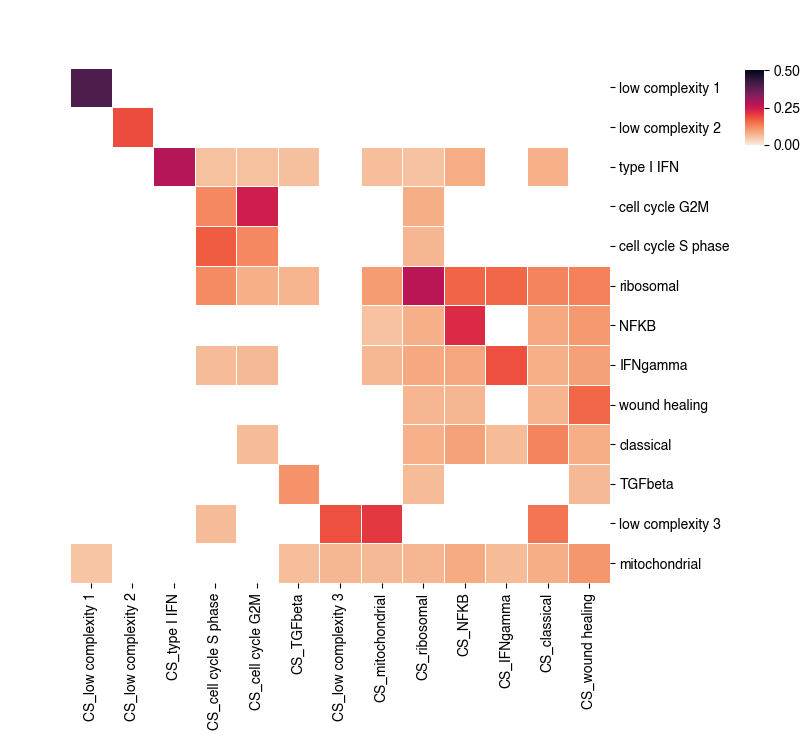

In [23]:
plate_module_matching(select_p1_scores, p2_gene_scores,
                     select_p1_top_genes, p2_top_genes, 
                      select_p1_usages, p2_normd_usages,
                      file_name = 'select_p1_validation_p2_CS_d7',jac_cutoff = 0.05, corr_cutoff = 0.4, 
                      filter_to_top=False)

In [32]:
few_pathways = ['NFKB','wound healing','TGFbeta','IFNgamma','ribosomal']
select_p1_scores = select_p1_scores.loc[:,few_pathways]
select_p1_top_genes = select_p1_top_genes.loc[:,few_pathways]
select_p1_usages = select_p1_usages.loc[:,few_pathways]




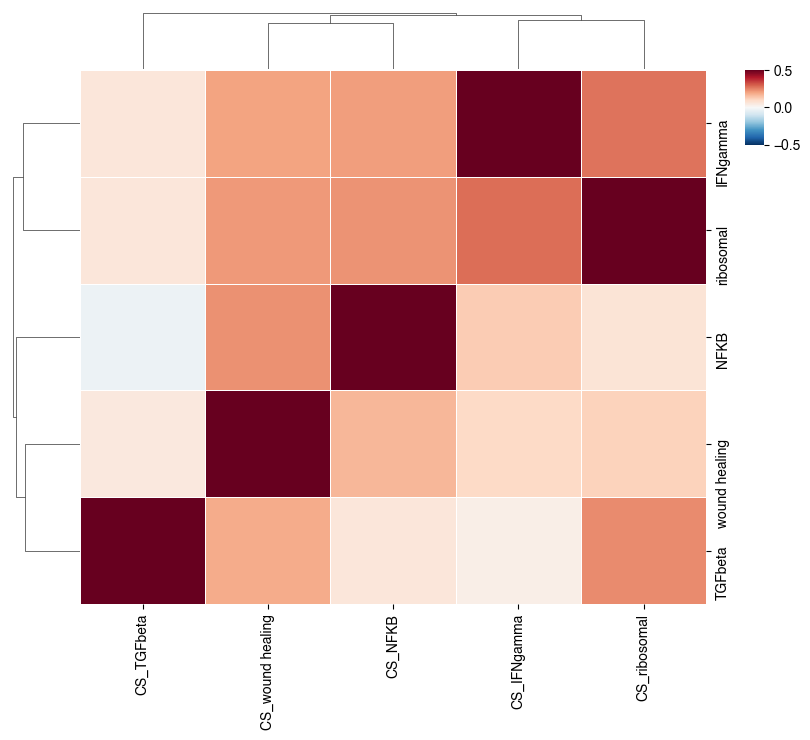

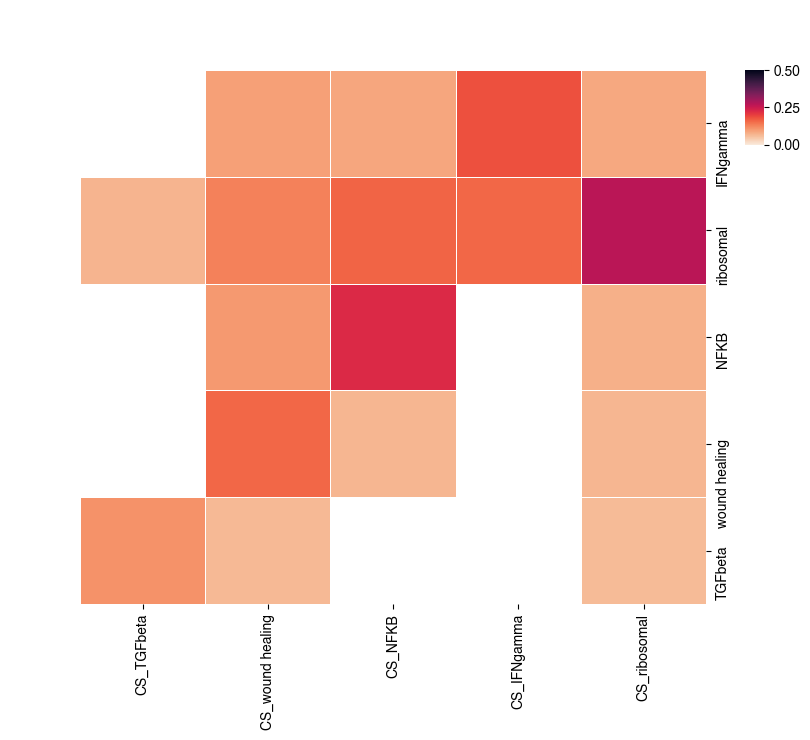

In [33]:
plate_module_matching(select_p1_scores, p2_gene_scores,
                     select_p1_top_genes, p2_top_genes, 
                      select_p1_usages, p2_normd_usages,
                      file_name = 'few_p1_validation_p2_CS_d7',jac_cutoff = 0.05, corr_cutoff = 0.4, 
                      filter_to_top=False)